In [1]:
# import libraries

import requests
import pandas as pd
import time
from datetime import datetime
import mysql.connector
from mysql.connector import Error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# top 10 coins

coins = [
    "bitcoin", "ethereum", "binancecoin", "ripple", "cardano",
    "solana", "dogecoin", "polkadot", "matic-network", "litecoin"
]

print(f"{len(coins)} coins")
print(coins)

10 coins
['bitcoin', 'ethereum', 'binancecoin', 'ripple', 'cardano', 'solana', 'dogecoin', 'polkadot', 'matic-network', 'litecoin']


In [3]:
# api testing

url = "https://api.coingecko.com/api/v3/simple/price"
params = {
    "ids": "bitcoin",
    "vs_currencies": "usd",
    "include_24hr_change": "true",
    "include_market_cap": "true",
    "include_24hr_vol": "true"
}

r = requests.get(url, params=params)
data = r.json()
print(data)

{'bitcoin': {'usd': 87916, 'usd_market_cap': 1754588590463.4473, 'usd_24h_vol': 71116458976.68376, 'usd_24h_change': 1.1315877380004769}}


In [4]:
# fetch data

ids = ",".join(coins)
url = "https://api.coingecko.com/api/v3/simple/price"

params = {
    "ids": ids,
    "vs_currencies": "usd",
    "include_market_cap": "true",
    "include_24hr_vol": "true",
    "include_24hr_change": "true"
}

r = requests.get(url, params=params)
data = r.json()

print(f"API Response Keys: {list(data.keys()) if data else 'No data'}")

records = []

for coin in coins:
    info = data.get(coin, {})  
    
    price = info.get("usd", 0)
    change = info.get("usd_24h_change", 0)
    market_cap = info.get("usd_market_cap", 0)
    volume = info.get("usd_24h_vol", 0)  

    records.append({
        "coin": coin.replace("-", " ").title(),
        "symbol": coin.split("-")[0].upper()[:10],
        "price": float(price) if price else 0.0,
        "change_24h": round(float(change), 2) if change else 0.0,
        "market_cap": float(market_cap) if market_cap else 0.0,
        "volume_24h": float(volume) if volume else 0.0,
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    })

df = pd.DataFrame(records)
df.head(10)

API Response Keys: ['binancecoin', 'bitcoin', 'cardano', 'dogecoin', 'ethereum', 'litecoin', 'matic-network', 'polkadot', 'ripple', 'solana']


,coin,symbol,price,change_24h,market_cap,volume_24h,timestamp
0,Bitcoin,BITCOIN,87936.000000,1.15,1.754292e+12,7.118173e+10,2025-11-25 12:12:33
1,Ethereum,ETHEREUM,2917.790000,2.73,3.521700e+11,2.831663e+10,2025-11-25 12:12:33
2,Binancecoin,BINANCECOI,860.080000,1.03,1.184930e+11,1.840867e+09,2025-11-25 12:12:33
3,Ripple,RIPPLE,2.240000,8.24,1.349609e+11,6.269381e+09,2025-11-25 12:12:33
4,Cardano,CARDANO,0.420916,2.00,1.539825e+10,7.097786e+08,2025-11-25 12:12:33
5,Solana,SOLANA,137.580000,4.98,7.698472e+10,5.659080e+09,2025-11-25 12:12:33
6,Dogecoin,DOGECOIN,0.150815,3.08,2.290307e+10,1.530385e+09,2025-11-25 12:12:33
7,Polkadot,POLKADOT,2.290000,0.38,3.753142e+09,2.007865e+08,2025-11-25 12:12:33
8,Matic Network,MATIC,0.000000,0.00,0.000000e+00,0.000000e+00,2025-11-25 12:12:33
9,Litecoin,LITECOIN,84.490000,0.90,6.467734e+09,5.833236e+08,2025-11-25 12:12:33


In [ ]:
# connect to mysql

import mysql.connector
from mysql.connector import Error

try:
    mydb = mysql.connector.connect(
        host="localhost",
        user="root",
        password="your password",    #enter your mysql password
        database="crypto_db"
    )
    cursor = mydb.cursor()
    print("MySQL connected!")
except Error as e:
    print("Error:", e)

MySQL connected!


In [6]:
# new table by removing existing ones

cursor.execute("drop table if exists crypto_prices")

cursor.execute('''
create table crypto_prices (
    id int auto_increment primary key,
    coin varchar(50),
    symbol varchar(20),
    price decimal(20,2),
    change_24h decimal(10,2),
    market_cap decimal(30,2),
    volume_24h decimal(30,2),
    timestamp datetime
)
''')

In [7]:
query = """
insert into crypto_prices 
(coin, symbol, price, change_24h, market_cap, volume_24h, timestamp) 
VALUES (%s, %s, %s, %s, %s, %s, %s)
"""

for i in range(len(df)):
    row = df.iloc[i]
    values = (
        row["coin"],
        row["symbol"],
        float(row["price"]),
        float(row["change_24h"]),
        float(row["market_cap"]),
        float(row["volume_24h"]),
        row["timestamp"]
    )
    cursor.execute(query, values)

mydb.commit()

In [8]:
# checking data

new = pd.read_sql("select * from crypto_prices order by timestamp desc limit 10", mydb)
new

,id,coin,symbol,price,change_24h,market_cap,volume_24h,timestamp
0,1,Bitcoin,BITCOIN,87936.00,1.15,1.754292e+12,7.118173e+10,2025-11-25 12:12:33
1,2,Ethereum,ETHEREUM,2917.79,2.73,3.521700e+11,2.831663e+10,2025-11-25 12:12:33
2,3,Binancecoin,BINANCECOI,860.08,1.03,1.184930e+11,1.840867e+09,2025-11-25 12:12:33
3,4,Ripple,RIPPLE,2.24,8.24,1.349609e+11,6.269381e+09,2025-11-25 12:12:33
4,5,Cardano,CARDANO,0.42,2.00,1.539825e+10,7.097786e+08,2025-11-25 12:12:33
5,6,Solana,SOLANA,137.58,4.98,7.698472e+10,5.659080e+09,2025-11-25 12:12:33
6,7,Dogecoin,DOGECOIN,0.15,3.08,2.290307e+10,1.530385e+09,2025-11-25 12:12:33
7,8,Polkadot,POLKADOT,2.29,0.38,3.753142e+09,2.007865e+08,2025-11-25 12:12:33
8,9,Matic Network,MATIC,0.00,0.00,0.000000e+00,0.000000e+00,2025-11-25 12:12:33
9,10,Litecoin,LITECOIN,84.49,0.90,6.467734e+09,5.833236e+08,2025-11-25 12:12:33


In [9]:
# loop for tracking crypto

print("updates every 2 minutes | press ctrl+C to stop | if in jupyter interrupt kernel to stop\n")

while True:
    try:
        r = requests.get(url, params=params)
        data = r.json()

        new_data = []
        for coin in coins:
            info = data.get(coin, {})
            new_data.append({
                "coin": coin.replace("-", " ").title(),
                "symbol": coin.split("-")[0].upper()[:10],
                "price": float(info.get("usd", 0)),
                "change_24h": round(float(info.get("usd_24h_change", 0)), 2),
                "market_cap": float(info.get("usd_market_cap", 0)),
                "volume_24h": float(info.get("usd_24h_vol", 0)),
                "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            })

        for row in new_data:
            values = (row["coin"], row["symbol"], row["price"], row["change_24h"],
                      row["market_cap"], row["volume_24h"], row["timestamp"])
            cursor.execute(query, values)
        
        mydb.commit()
        
        btc_price = new_data[0]["price"]
        btc_change = new_data[0]["change_24h"]
        print(f"{datetime.now().strftime('%H:%M:%S')} | BTC: ${btc_price:,.2f} | 24h: {btc_change:+.2f}%")

        time.sleep(120)  # 2 minutes

    except Exception as e:
        print("Error, retrying in 60 sec...", e)
        time.sleep(60)

updates every 2 minutes | press ctrl+C to stop | if in jupyter interrupt kernel to stop

12:12:34 | BTC: $87,936.00 | 24h: +1.15%
12:14:36 | BTC: $87,860.00 | 24h: +1.07%
12:16:38 | BTC: $87,857.00 | 24h: +1.06%
12:18:39 | BTC: $87,914.00 | 24h: +1.11%
12:20:40 | BTC: $87,851.00 | 24h: +1.04%
12:22:45 | BTC: $87,809.00 | 24h: +0.99%
12:24:47 | BTC: $87,843.00 | 24h: +1.03%
12:26:49 | BTC: $87,850.00 | 24h: +1.04%
12:28:50 | BTC: $88,048.00 | 24h: +1.26%
12:30:52 | BTC: $87,974.00 | 24h: +1.18%
12:32:53 | BTC: $87,942.00 | 24h: +1.29%
12:34:55 | BTC: $87,920.00 | 24h: +1.26%
12:36:56 | BTC: $87,848.00 | 24h: +1.18%
12:38:57 | BTC: $87,886.00 | 24h: +1.23%
12:40:59 | BTC: $87,969.00 | 24h: +1.35%
12:43:00 | BTC: $87,998.00 | 24h: +1.38%
12:45:02 | BTC: $88,037.00 | 24h: +1.43%
12:47:03 | BTC: $87,967.00 | 24h: +1.22%
12:49:05 | BTC: $87,955.00 | 24h: +1.21%
12:51:06 | BTC: $87,845.00 | 24h: +1.08%
12:53:07 | BTC: $87,901.00 | 24h: +1.21%
12:55:09 | BTC: $87,846.00 | 24h: +1.14%
12:57:10 

KeyboardInterrupt: 

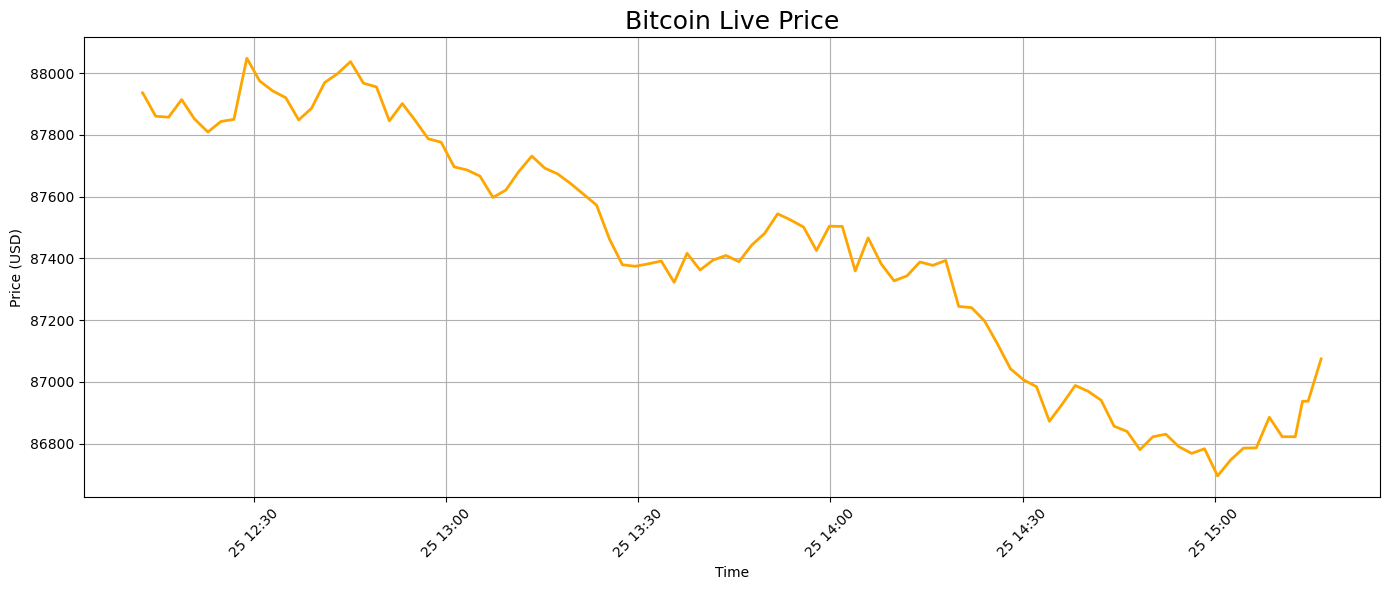

In [17]:
# price chart

btc = pd.read_sql("select timestamp, price from crypto_prices where coin='Bitcoin' order by timestamp", mydb)
btc["timestamp"] = pd.to_datetime(btc["timestamp"])

plt.figure(figsize=(14,6))
plt.plot(btc["timestamp"], btc["price"], color="orange", linewidth=2)
plt.title("Bitcoin Live Price", fontsize=18)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# top gainers & losers

latest = pd.read_sql("""
    select coin, price, change_24h from crypto_prices 
    where timestamp = (select max(timestamp) from crypto_prices)
""", mydb)

gainers = latest.sort_values("change_24h", ascending=False).head(5)
losers = latest.sort_values("change_24h").head(5)

print("TOP GAINERS")
print(gainers[["coin", "change_24h"]])

print("\nTOP LOSERS")
print(losers[["coin", "change_24h"]])

TOP GAINERS
       coin  change_24h
3    Ripple        7.78
5    Solana        5.15
1  Ethereum        3.08
6  Dogecoin        2.60
4   Cardano        2.31

TOP LOSERS
            coin  change_24h
8  Matic Network        0.00
7       Polkadot        0.26
2    Binancecoin        0.92
9       Litecoin        1.13
0        Bitcoin        1.26


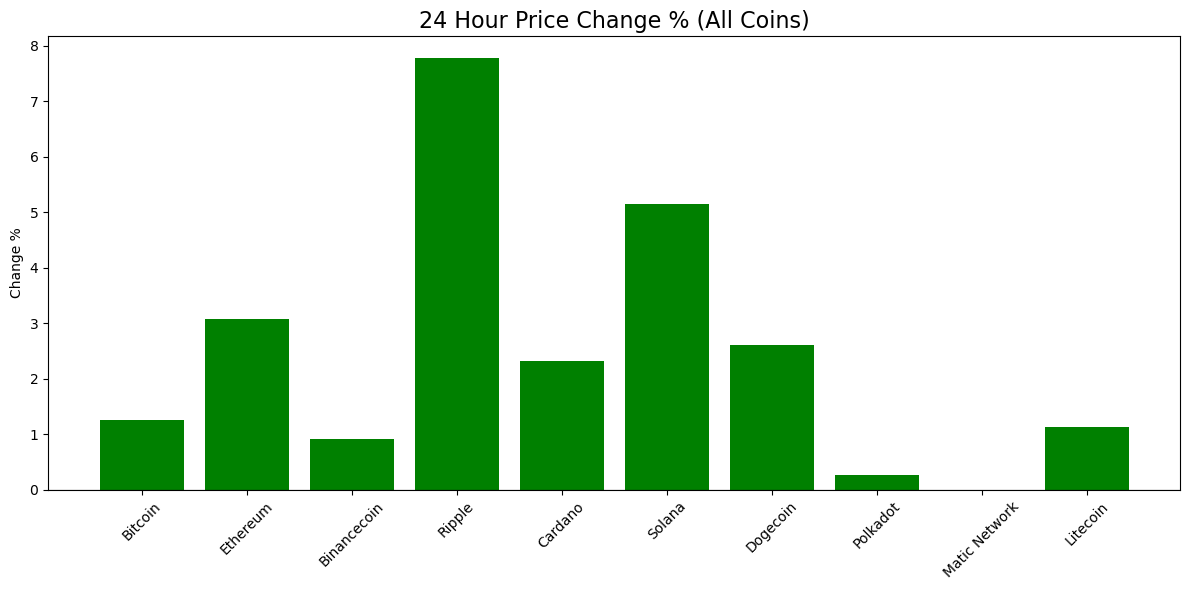

In [12]:
# Bar Chart: 24h Change

plt.figure(figsize=(12,6))
colors = ['green' if x > 0 else 'red' for x in latest["change_24h"]]
plt.bar(latest["coin"], latest["change_24h"], color=colors)
plt.title("24 Hour Price Change % (All Coins)", fontsize=16)
plt.ylabel("Change %")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

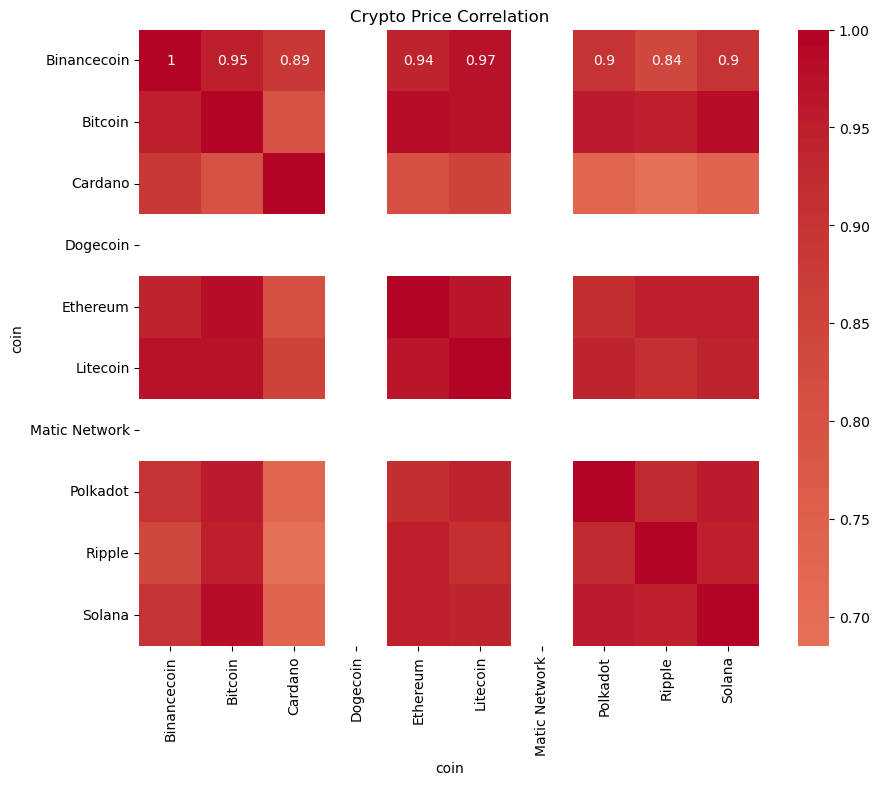

In [20]:
# Correlation Heatmap

pivot = pd.read_sql("select timestamp, coin, price from crypto_prices", mydb)
pivot = pivot.pivot(index="timestamp", columns="coin", values="price")
corr = pivot.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Crypto Price Correlation")
plt.show()

In [21]:
# daily returns heatmap

returns = pd.read_sql("""
    select 
        date(timestamp) as trade_date,
        coin,
        change_24h
    from crypto_prices 
    where timestamp > date_sub(curdate(), interval 8 day)
""", mydb)

returns_clean = returns.groupby(['trade_date', 'coin'], as_index=False).last()

returns_pivot = returns_clean.pivot(index='trade_date', columns='coin', values='change_24h')

returns_pivot = returns_pivot.fillna(0)

returns_pivot.tail(10)

coin,Binancecoin,Bitcoin,Cardano,Dogecoin,Ethereum,Litecoin,Matic Network,Polkadot,Ripple,Solana
trade_date,,,,,,,,,,
2025-11-25,0.92,1.26,2.31,2.6,3.08,1.13,0.0,0.26,7.78,5.15


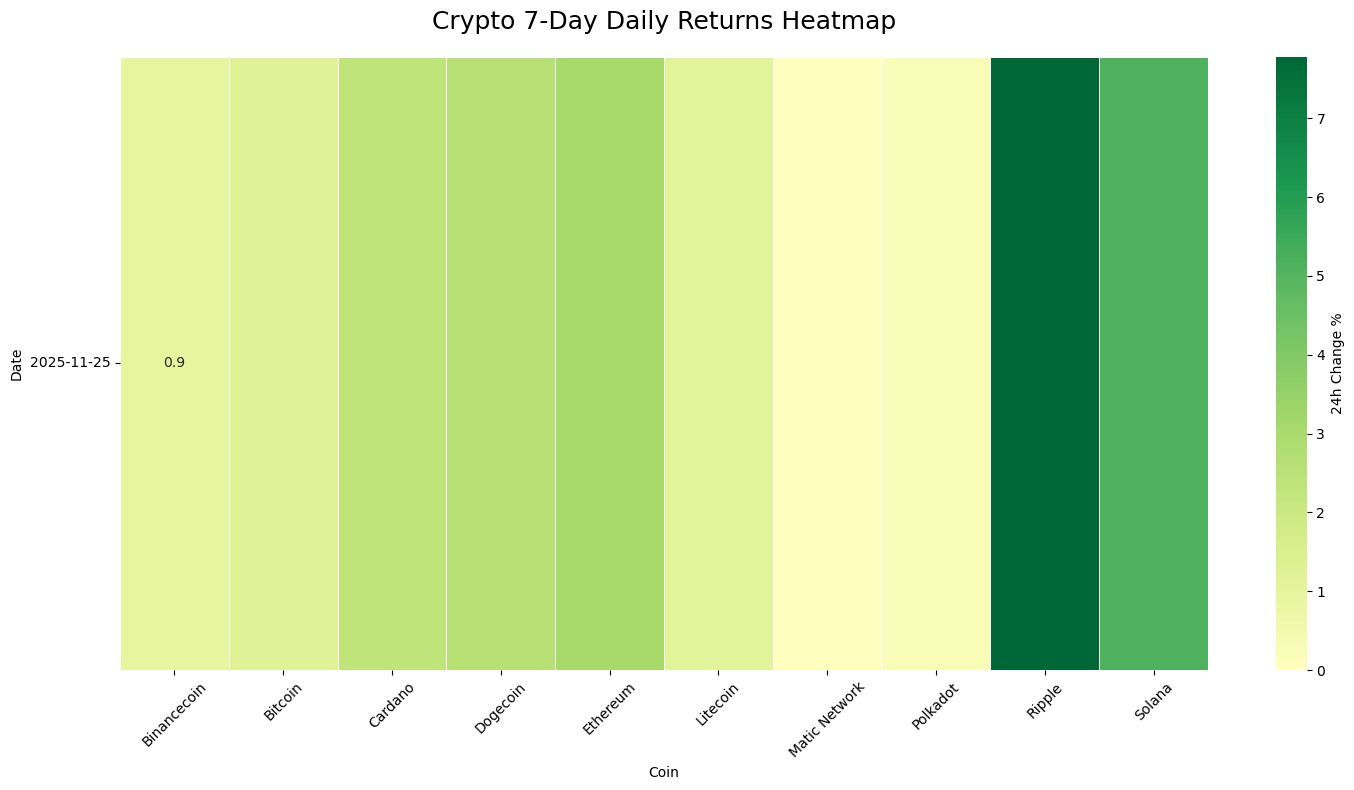

In [22]:
# final Heatmap

plt.figure(figsize=(15, 8))
sns.heatmap(
    returns_pivot, 
    annot=True, 
    fmt=".1f", 
    cmap="RdYlGn", 
    center=0, 
    linewidths=0.5, 
    cbar_kws={'label': '24h Change %'}
)

plt.title("Crypto 7-Day Daily Returns Heatmap", fontsize=18, pad=20)
plt.xlabel("Coin")
plt.ylabel("Date")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

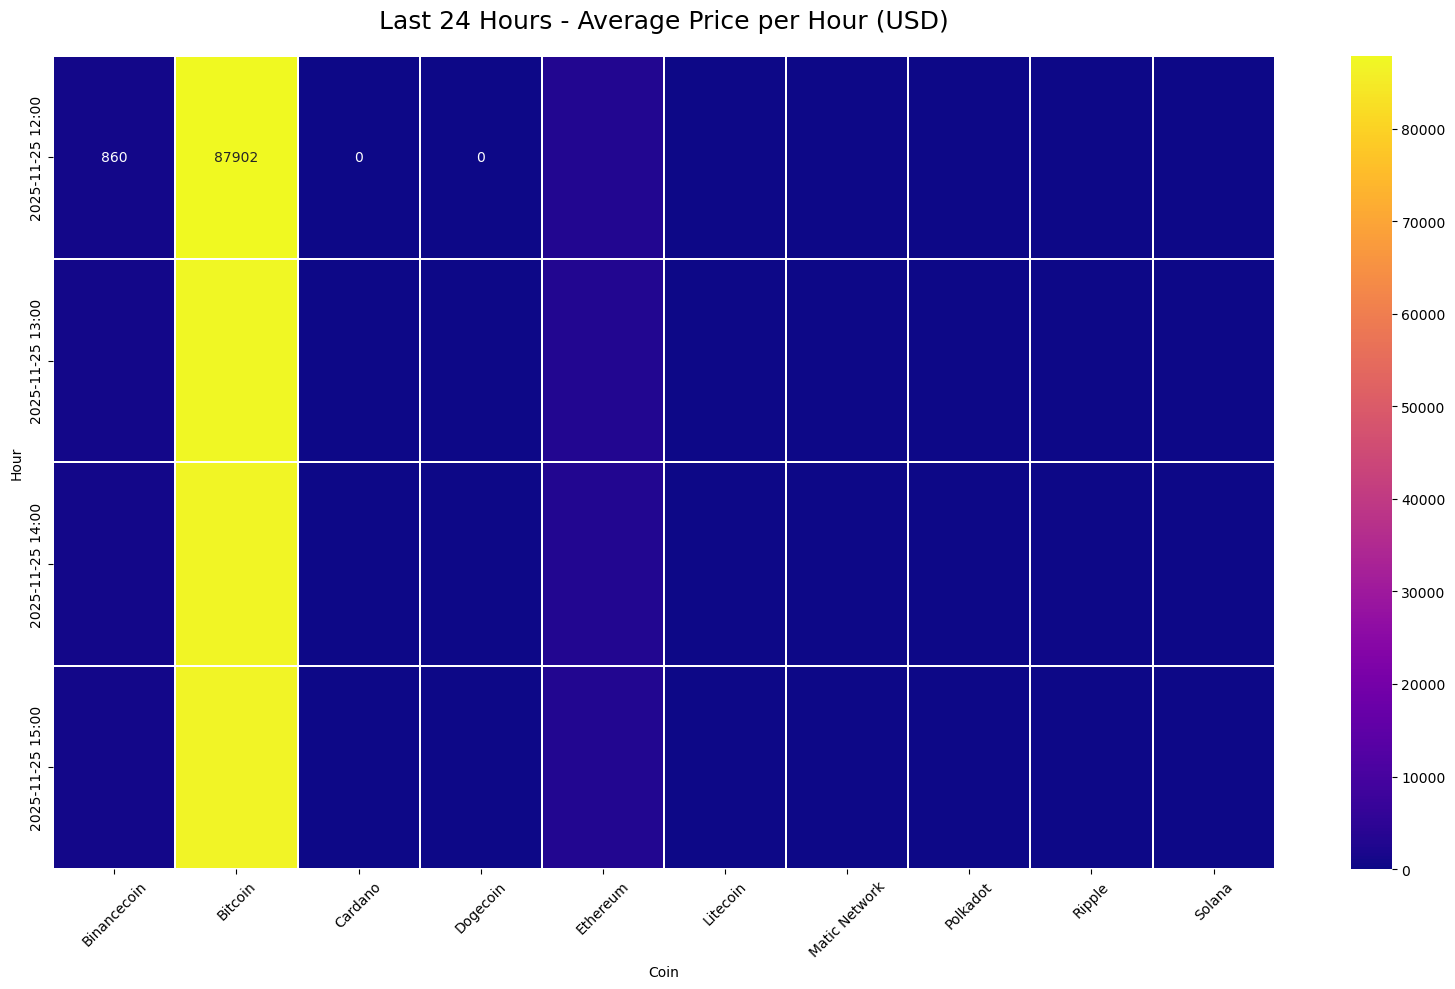

24-Hour Price Heatmap ready!


In [16]:
hourly = pd.read_sql("""
    select 
        date_format(timestamp, '%Y-%m-%d %H:00') as hour,
        coin,
        avg(price) as avg_price
    from crypto_prices 
    where timestamp > date_sub(now(), interval 25 hour)
    group by hour, coin
    order by hour
""", mydb)

hour_pivot = hourly.pivot(index='hour', columns='coin', values='avg_price')
hour_pivot = hour_pivot.fillna(method='ffill').fillna(method='bfill')

plt.figure(figsize=(16, 10))
sns.heatmap(hour_pivot, annot=True, fmt=".0f", cmap="plasma", linewidths=0.3)
plt.title("Last 24 Hours - Average Price per Hour (USD)", fontsize=18, pad=20)
plt.xlabel("Coin")
plt.ylabel("Hour")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("24-Hour Price Heatmap ready!")